In [2]:
import pandas as pd
import os
import torch
import sklearn as sl
import numpy as np
from torch import nn
import torch.nn.functional as F

## Data Simulation
We simulate two risk classes. We simulate parameters to be sampled from a Gamma distribution. Parameters are randomly sampled by samples in risk characteristics as follows:

$\hat{\theta}_{low} = 1 + \beta_{1} X_{1} + \beta_{2} X_{2} $

$\hat{\theta}_{high} = 2 + 2 \beta_{1} X_{1} + 2 \beta_{2} X_{2} $

$\hat{\alpha}_{low} = 1 + 0.1 \beta_{1} X_{1} + 0.1 \beta_{2} X_{2} $

$\hat{\alpha}_{high} = 1 + 0.2 \beta_{1} X_{1} + 0.2 \beta_{2} X_{2} $

**Where samples from each class are defined as:**

$\hat{Y}_{low} \:$~$\: Gamma(\alpha = \hat{\alpha}_{low}, \theta = \hat{\theta}_{low}) $

$\hat{Y}_{high} \:$~$\: Gamma(\alpha = \hat{\alpha}_{high}, \theta = \hat{\theta}_{high}) $

**Our characteristic distribution is as follows:**

$X_{1},X_{2} \:$~$\: Normal(\mu = 5, \sigma = 1) $

$\beta_{1},\beta_{2} \:$~$\: Normal(\mu = 2, \sigma = 0.5) $

In [3]:
from functions import downloadData


alpha_low = 1
alpha_high = 2
theta = 10
samples = 1000

low_risk_samples = np.random.gamma(shape = alpha_low, scale = theta, size = samples)
high_risk_samples = np.random.gamma(shape = alpha_low, scale = theta, size = samples)

array([1.80088853e+01, 1.29741776e+01, 1.54390040e+01, 1.30943751e+01,
       1.07598860e+01, 7.39662397e+00, 4.87416418e+00, 5.90993092e+00,
       6.82339212e+00, 8.10266452e+00, 5.35990121e+00, 3.95842115e+00,
       2.97208668e+00, 1.52331210e+01, 7.16879989e+00, 1.51145265e+01,
       1.43435872e+00, 4.35322256e-01, 2.64263949e+01, 5.28115656e+00,
       2.94605954e+00, 4.81933051e+01, 1.67765805e+00, 1.94002425e+01,
       1.16383649e+01, 1.92400039e+01, 1.10835868e+01, 3.53367429e+00,
       1.20953092e+00, 1.58645011e+00, 1.54870976e+01, 3.03472426e+01,
       1.35813995e+00, 3.83926644e+00, 7.06432321e+00, 7.95757284e+00,
       2.54749169e+01, 2.12503767e+00, 1.30986876e+01, 3.87183756e+01,
       1.16546447e+01, 9.15244858e-01, 2.53055231e+01, 4.70799657e+00,
       4.24319609e+00, 4.09267508e+00, 3.66363622e-01, 1.31898704e+01,
       1.08515934e+00, 9.69341519e-01, 1.99692194e+01, 1.61586198e+00,
       3.60296405e+01, 5.32264877e-02, 7.35888090e+00, 1.96828008e+00,
      

In [3]:
data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


**Data Transform**

In [4]:
from functions import transformData

transformed_data = transformData(data)

In [15]:
transformed_data.head(5)

,overall,overall_positive,we,got,this,gps,for,my,husband,over,...,figured,micro,booting,cm,capabilities,running,rd,party,stock,form
0,4,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,0,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,1


## Modelling

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [33]:
from functions import NeuralNetworkBinary
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#We need to first rebalance the transformed dataset. (can't use weights due to loss function not supporting)
data_class_1 = transformed_data[transformed_data.overall_positive==1]
data_class_0 = transformed_data[transformed_data.overall_positive==0]

class_1_resampled = resample(data_class_1, replace=False, n_samples=len(data_class_0), random_state=123)
transformed_data = pd.concat([data_class_0, class_1_resampled])

#Create data frames for x and y
response_var_binary = transformed_data['overall_positive']
predictor_var = transformed_data.drop(['overall_positive', 'overall'], axis = 1)

#Create test and train datasets
X_train_binary, X_test_binary, Y_train_binary, Y_test_binary = train_test_split(predictor_var, response_var_binary, test_size=0.5, random_state=42, stratify=response_var_binary)

#Create tensors
response_var_binary_t = torch.tensor(Y_train_binary.values, dtype = torch.float32).to(device)
predictor_var_t = torch.tensor(X_train_binary.values, dtype = torch.float32).to(device)

#Create model
n_columns = len(transformed_data.columns)-2

model = NeuralNetworkBinary(n_input = n_columns, n_hidden_layer = n_columns, n_output = 1, learning_rate = 0.0075).to(device)
print(model)

NeuralNetworkBinary(
  (model): Sequential(
    (0): Linear(in_features=1990, out_features=1990, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1990, out_features=1990, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1990, out_features=1990, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1990, out_features=1990, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1990, out_features=1, bias=True)
    (9): Sigmoid()
  )
  (loss_function): BCELoss()
)


250 iterations complete, current test accuracy: 0.50, curr entropy: 0.6929418444633484
250 iterations complete, current test accuracy: 0.61, curr entropy: 0.6926767230033875
250 iterations complete, current test accuracy: 0.62, curr entropy: 0.6923990249633789
250 iterations complete, current test accuracy: 0.62, curr entropy: 0.6920846104621887
250 iterations complete, current test accuracy: 0.63, curr entropy: 0.6917116045951843
250 iterations complete, current test accuracy: 0.63, curr entropy: 0.6912558674812317
250 iterations complete, current test accuracy: 0.64, curr entropy: 0.6906790733337402
250 iterations complete, current test accuracy: 0.64, curr entropy: 0.6899295449256897
250 iterations complete, current test accuracy: 0.64, curr entropy: 0.6889246702194214
250 iterations complete, current test accuracy: 0.65, curr entropy: 0.6875369548797607
250 iterations complete, current test accuracy: 0.65, curr entropy: 0.6855517625808716
250 iterations complete, current test accur

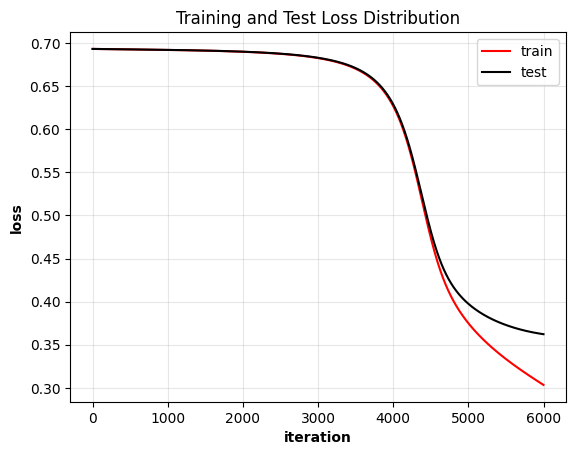

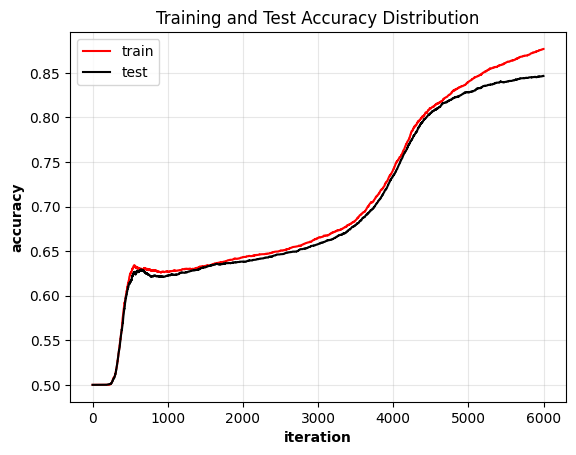

best accuracy achieved at iteration 5987 with accuracy 0.85


In [34]:
#Convert test data to tensors
Y_test_binary_t = torch.tensor(Y_test_binary.values, dtype = torch.float32).to(device)
X_test_binary_t = torch.tensor(X_test_binary.values, dtype = torch.float32).to(device)

model.train(x_train = predictor_var_t, y_train = response_var_binary_t, batch_size=6000, x_test = X_test_binary_t, y_test = Y_test_binary_t)

## Model Diagnostics ##

In [35]:
from utils import accuracy

X_test_binary_t = torch.tensor(X_test_binary.values, dtype = torch.float32).to(device)

predictions_binary = model.model(X_test_binary_t).detach().cpu().numpy()
#Turn probability into prediction
predictions_binary = np.where(predictions_binary > 0.5, 1, 0)

accuracy(Y_test_binary, predictions_binary)

Accuracy: 0.8466360586261699
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      5663
           1       0.84      0.85      0.85      5663

    accuracy                           0.85     11326
   macro avg       0.85      0.85      0.85     11326
weighted avg       0.85      0.85      0.85     11326



Confusion Matrix:

False Positives: 907
False Negatives: 830
True Positives: 4833
True Negatives: 4756


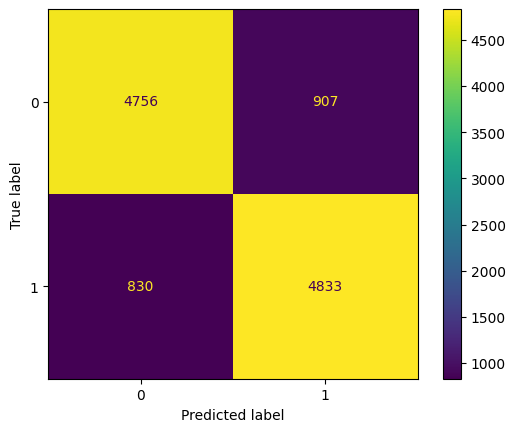

In [36]:
from utils import confusionMatrix

confusionMatrix(Y_test_binary, predictions_binary)